# Simulation of the Heston Model

**Mekrami Redwan**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import scipy.stats as ss
import scipy.integrate
import math
import cmath


sns.set_theme()

# Heston Model

The basic Heston model assumes that $S_{t}$, the price of the asset, is determined by a stochastic process, ${ }^{[2]}$
$$
d S_{t}=\mu S_{t} d t+\sqrt{\nu_{t}} S_{t} d W_{t}^{S},
$$
where $\nu_{t}$, the instantaneous variance, is given by a Feller square-root or $\mathrm{CIR}$ process,
$$
d \nu_{t}=\kappa\left(\theta-\nu_{t}\right) d t+\xi \sqrt{\nu_{t}} d W_{t}^{\nu}
$$

## Paths implementation

In [2]:
Npaths = 10**5

T = 3
steps = 40
dt = T/steps

rho = -0.9


kappa = 2
theta = 0.3
v_0 = 0.3
xi = 0.9

W = np.random.randn(Npaths,steps)
Z_X = np.random.randn(Npaths,steps)  
Z_V = rho * Z_X + np.sqrt(1-rho**2)*W

### Discretisation

#### Euler Scheme

Euler-Maruyama scheme: 
$$
S_{t+d t}=S_{t}( 1 + r dt+\sqrt{v_{t} d t}Z_{s})
$$
and
$$
v_{t+d t}=v_{t}+\kappa\left(\theta-v_{t}^{+}\right) d t+\sigma \sqrt{v_{t}^{+} d t} Z_{v}
$$
where $x^{+}=\max (0, x)$ and where $Z_{s}$ and $Z_{v}$ are standardized Gaussian random variables such that $corr(Z_{s}, Z_{v}) = ρ$.


In [3]:
def generate_heston_euler(S = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, steps = 360, T=1):
    '''
      Generate Heston Volatility and Asset Paths With Euler Scheme
      Args:
          S:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
          steps:
            Number of discretization steps
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
          X_bs :
            Asset Path under Black Scholes
    '''
    dt = T/steps
    size = (Npaths, steps)
    W = np.random.randn(Npaths,steps)
    Z_X = np.random.randn(Npaths,steps)  
    Z_V = rho * Z_X + np.sqrt(1-rho**2)*W
    X = np.zeros(Npaths)+ S
    V = np.zeros(Npaths)+v_0
    
    for t in range(steps-1): 
        X = X * (1 + r*dt+ np.sqrt(np.maximum(V, 0) *dt) * Z_X[:,t])
        V = V + kappa * (theta - np.maximum(V, 0))*dt + ( xi * np.sqrt(np.maximum(V, 0) * dt) * Z_V[:,t])

    return X, V   


#### Milstein Scheme

Black Scholes:

$$S_{t+d t}=S_{t}+r S_{t} dt + \sigma S_{t} \sqrt{dt} Z+ \frac{1}{2} \sigma^{2}S_{t} dt\left(Z^{2}-1\right)$$

Heston :

$$
S_{t+d t}=S_{t}+r S_{t} dt+\sqrt{v_{t}^{+} d t} S_{t} Z_{s}+\frac{1}{2} v_{t}^{+} S_{t} d t\left(Z_{s}^{2}-1\right)
$$

$$
v_{t+d t}=v_{t}+\kappa\left(\theta-v_{t}^{+}\right) d t+\sigma \sqrt{v_{t}^{+} d t} Z_{v}+\frac{1}{4} \sigma^{2} d t\left(Z_{v}^{2}-1\right)
$$

In [4]:
def generate_heston_milstein(S = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, steps = 360, T=1):
    '''
      Generate Heston Volatility and Asset Paths with Milstein Scheme
      Args:
          S:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
          steps:
            Number of discretization steps
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
          X_bs :
            Asset Path under Black Scholes
    '''
    dt = T/steps
    size = (Npaths, steps)
    W = np.random.randn(Npaths,steps)
    Z_X = np.random.randn(Npaths,steps)  
    Z_V = rho * Z_X + np.sqrt(1-rho**2)*W
    X = np.zeros(Npaths) +S
    V = np.zeros(Npaths) + v_0
    for t in range(steps-1): 
        X = X * ( 1 + r*dt+ (np.sqrt(np.maximum(V, 0) *dt) * Z_X[:,t]) + (0.5 * np.maximum(V, 0)* dt * ((Z_X[:,t]**2) - 1)) )
        V = V + (kappa * dt * (theta - np.maximum(V, 0))) + (xi * np.sqrt(np.maximum(V, 0) * dt) * Z_V[:,t]) + (0.25 * (xi**2) * dt * ((Z_V[:,t]**2) - 1))
    return X, V

#### Andersen Approximation

In [5]:
from scipy.stats import norm

def generate_heston_andersen(S = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, steps = 360, T=1,nu_c=1.5):
    '''
      Generate Heston Volatility and Asset Paths With Andersen Scheme
      Args:
          S:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
          steps:
            Number of discretization steps
          nu_c :
            Andersen Constant
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
    '''
    dt = T/steps
    size = (Npaths,steps)
    V = np.zeros(Npaths)+v_0
    X = np.zeros(Npaths)+S
    lnX = np.zeros(size)

    gamma_1 = 1    #0.5 
    gamma_2 = 0   #0 

    for t in range(steps-1):
      m = theta + (V - theta) * np.exp(-kappa*dt) # ok
      s = (V * (xi**2) * np.exp(-kappa*dt)/kappa) * (1-np.exp(-kappa*dt)) + ( theta * (xi**2)/ (2*kappa) ) *(1-np.exp(-kappa*dt))**2  # ok 
      nu = s/(m**2) #ok

      U = np.random.uniform(size = Npaths) 

      b =( (2/nu)-1 + np.sqrt(2/nu)*np.sqrt((2/nu) -1) )**0.5  # ok
      a = m/(1+b**2) # ok

      Z = norm.ppf(U)
      
      p = (nu - 1) /(nu + 1)  # ok
      beta = (1-p)/m  # ok

      K_0 = -dt*(kappa*rho*theta)/xi  
      K_1 = gamma_1*dt*(kappa*rho/xi - 0.5) - rho/xi
      K_2 = gamma_2*dt*(kappa*rho/xi - 0.5) + rho/xi
      K_3 = gamma_1*dt*(1 - rho**2)
      K_4 = gamma_2*dt*(1 - rho**2)
      
      V_old = V
      V = (nu <= nu_c) * a*(b + Z)**2 + (nu > nu_c) *  (1>=U)*(U>p) * (1/beta) * np.log((1-p)/(1-U))
      X = X * np.exp(r*dt+K_0 + K_1 * V_old + K_2 * V + np.sqrt(K_3* V_old +  K_4*V) * np.random.randn(Npaths))
    return X, V  

#### Alomst exact approximation

The basic Heston model assumes that $S_{t}$, the price of the asset, is determined by a stochastic process, ${ }^{[2]}$
$$
d S_{t}=\mu S_{t} d t+\sqrt{\nu_{t}} S_{t} d W_{t}^{S},
$$
where $\nu_{t}$, the instantaneous variance, is given by a Feller square-root or $\mathrm{CIR}$ process,
$$
d \nu_{t}=\kappa\left(\theta-\nu_{t}\right) d t+\xi \sqrt{\nu_{t}} d W_{t}^{\nu}
$$

In [6]:
from scipy.stats import norm

def generate_heston_almost_exact(S = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, steps = 360, T=1):
    '''
      Generate Heston Volatility and Asset Paths With Almost Exact Scheme
      Args:
          S:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
          steps:
            Number of discretization steps
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
    '''
    dt = T/steps
    size = (Npaths,steps)
    V = np.zeros(Npaths) + v_0
    X = np.zeros(Npaths) + np.log(S)



    for t in range(steps-1):
      c_bar = ((xi**2)/(4*kappa)) * (1- np.exp(-kappa*dt))
      delta = (4*kappa*theta)/(xi**2)
      k_bar = V*(4*kappa*np.exp(-kappa*dt))/((xi**2)*(1-np.exp(-kappa*dt)))
      Z = np.random.randn(Npaths)
      Y = np.random.noncentral_chisquare(df= delta, nonc =k_bar, size = Npaths)
      
      K_0 = dt*(r - kappa*rho*theta/xi)
      K_1 = dt*(kappa*rho/xi - 0.5) - rho/xi
      K_2 = rho/xi
      K_3 = dt*(1- rho**2)

      V_old = V
      V = c_bar * Y
      X = X + K_0 + (K_1 * V_old)  + (K_2 * V) + (np.sqrt(K_3 *V_old) * Z)
    return np.exp(X), V

## Pricing


### Benchmark




In [7]:
i=complex(0,1)

def HestonCallClosedForm(S0 = 100 , K= 100, kappa = 4, theta = 0.3, xi = 0.9, v0 = 0.3, r = 0.02, tau = 1):
    '''
      Compute Heston Theorical Call Price
      Args:
          S0:
            Spot Price of the Underlying
          K :
            Strike Price
          r:
            Risk Free Rate
          tau:
            Time to Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
      Returns:
          Theorical price of the call under Heston Model
    '''
    def PIntegrand(u, kappa, theta, xi, v0, r, tau, S0, K, j):
            F = S0*math.exp(r*tau)
            x = cmath.log(F/K)
            a = kappa * theta
            
            if j == 1 :
                b = kappa - rho*xi
                alpha = - u**2/2 - u/2 * i + i * u
                beta = kappa - rho * xi - rho *xi * i * u
            else:
                b = kappa
                alpha = - u**2/2 - u/2 * i
                beta = kappa - rho*xi*i*u
            
            gamma = xi**2/2
            d = cmath.sqrt(beta**2 - 4*alpha*gamma)
            rplus = (beta + d)/(2*gamma)
            rminus = (beta - d)/(2*gamma)
            g = rminus/rplus
            
            D = rminus*(1 - cmath.exp(-d*tau))/(1-g*cmath.exp(-d*tau))
            C = kappa*(rminus * tau - 2/(xi**2) * cmath.log((1-g*cmath.exp(-d*tau))/(1-g)))
            
            top = cmath.exp(C*theta + D*v0 + i*u*x)
            bottom = (i*u)
            return (top/bottom).real

    def P(kappa, theta, xi, v0, r, tau, S0, K, j):
            value = scipy.integrate.quad(PIntegrand, 0, np.inf, args=(kappa, theta, xi, v0, r, tau, 
                               S0, K, j))[0]
            return 0.5 + (1/math.pi)*value
    A = S0*P(kappa, theta, xi, v0, r, tau, S0, K, 1)
    B = K*cmath.exp(-r*tau)*P(kappa, theta, xi, v0, r, tau, S0, K, 0)
    return A-B

HestonCallClosedForm(S0=100, K = 30,kappa = kappa, theta = theta, v0 =v_0 , xi = xi,tau=T)

(74.47881138061106+0j)

In [8]:
def call_price(path, K = 100, r = 0.02, T = 1):
    '''
      Compute the price of Call
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The price of a Call with Monte carlo
      '''
    S_T = np.array(path)
    Z = np.maximum(S_T-K, 0)
    return(np.exp(-r*T) * Z)

### Euler Discretization

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


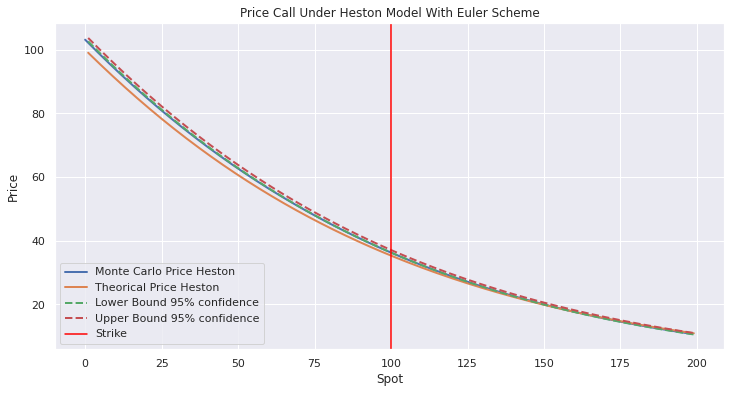

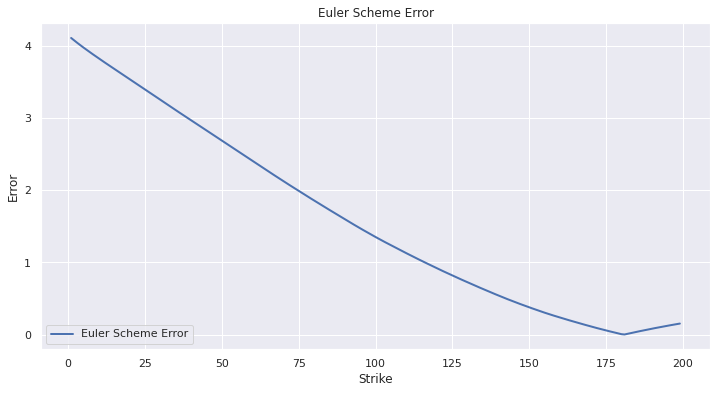

In [9]:
def call_strike_payoff_heston_euler():
    '''
      Compute Heston Call Price Function of Strikes With Euler Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_euler(S = 100, r = 0.02, kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = steps, T= T)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(S0=100, K = k,kappa = kappa, theta = theta, v0 =v_0 , xi = xi,tau=T)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_euler, ic_length_euler = call_strike_payoff_heston_euler()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Euler Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_euler, linewidth=2, label = 'Euler Scheme Error')
plt.title('Euler Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Error')
plt.legend(loc = 'lower left')
plt.show()

### Milstein

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


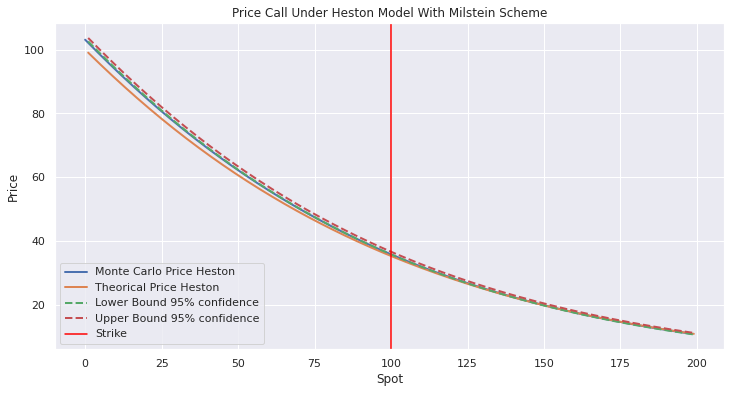

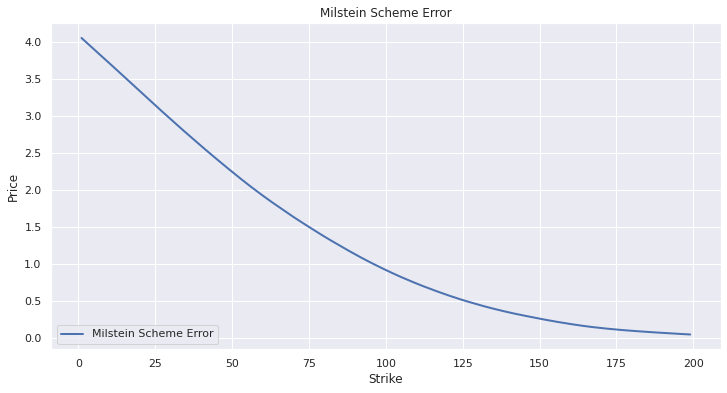

In [10]:
def call_strike_payoff_heston_milstein():
    '''
      Compute Heston Call Price Function of Strikes With Milstein Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_milstein(S = 100, r = 0.02, kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = steps, T= T)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(S0=100, K = k, kappa = kappa, theta = theta, v0 =v_0 , xi = xi,tau=T)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_milstein, ic_length_milstein = call_strike_payoff_heston_milstein()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Milstein Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_milstein, linewidth=2, label = 'Milstein Scheme Error')
plt.title('Milstein Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

###  Andersen : Quadratic Explonential

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


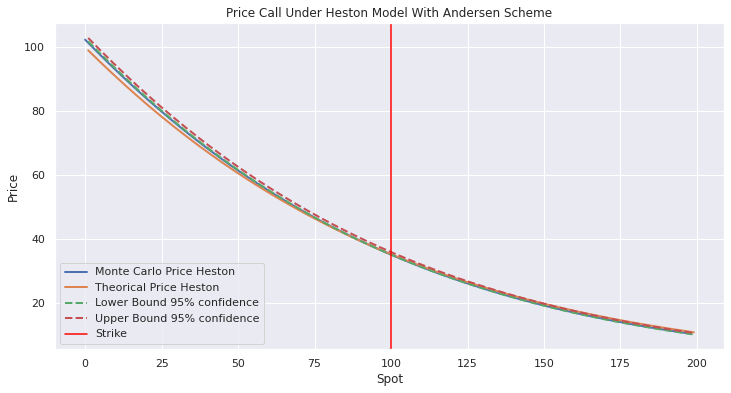

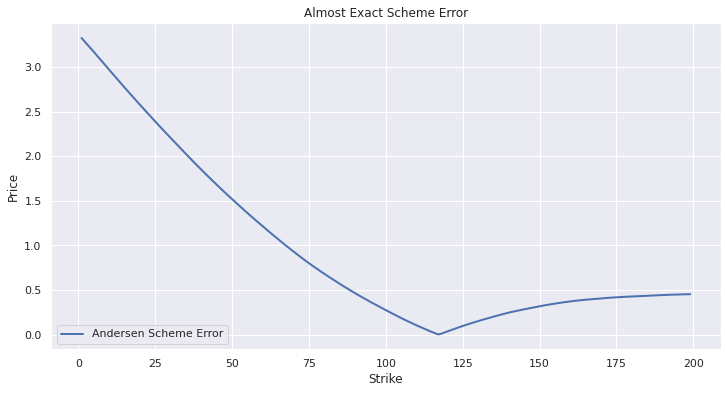

In [11]:
start = 1
def call_strike_payoff_heston_andersen():
    '''
      Compute Heston Call Price Function of Strikes With Andersen Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_bound:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''  
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_andersen(S = 100, r = 0.02, kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = steps, T= T, nu_c=2)[0]

    for k in range(start,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(S0=100, K = k,kappa = kappa, theta = theta, v0 =v_0 , xi = xi,tau=T)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_andersen, ic_length_andersen = call_strike_payoff_heston_andersen()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(start,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(start,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(start,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Andersen Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(start,200), error_andersen, linewidth=2, label = 'Andersen Scheme Error')
plt.title('Almost Exact Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

### Almost Exact Scheme

error 0.630330533265834
ic lenght 0.9106883374285246
error 0.002187042958766483
ic lenght 0.7974159504539386
error 0.3827437590302587
ic lenght 0.6816409363639835


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


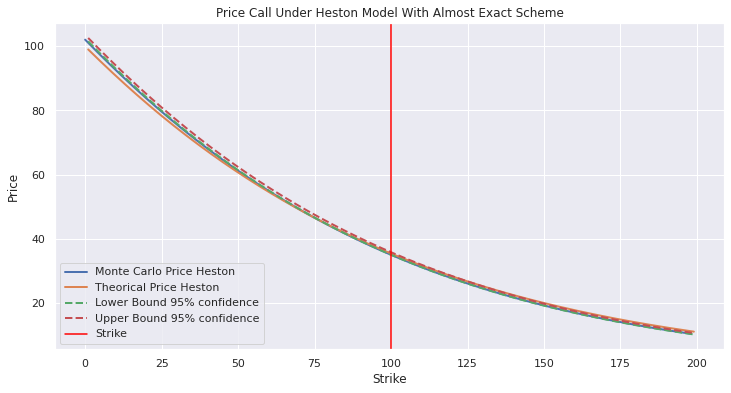

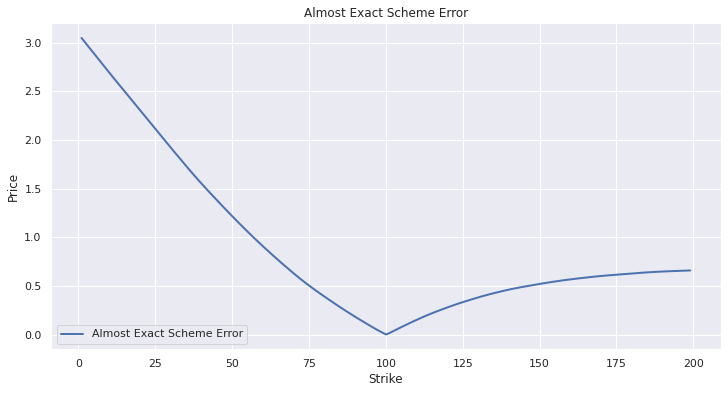

In [12]:
start = 1
def call_strike_payoff_heston_almost_exact():
    '''
      Compute Heston Call Price Function of Strikes With Almost Exact Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_almost_exact(S = 100, r = 0.02, kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = steps, T= T)[0]

    for k in range(start,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(S0=100, K = k,kappa = kappa, theta = theta, v0 =v_0 , xi = xi,tau=T)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)
        if(k==70 or k == 100 or k == 130):
          print('error', np.abs(th_price-p))
          print('ic lenght',up - down )

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_almost, ic_length_almost = call_strike_payoff_heston_almost_exact()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(start,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(start,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(start,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Almost Exact Scheme')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(start,200), error_almost, linewidth=2, label = 'Almost Exact Scheme Error')
plt.title('Almost Exact Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()



### Errors Comparaison

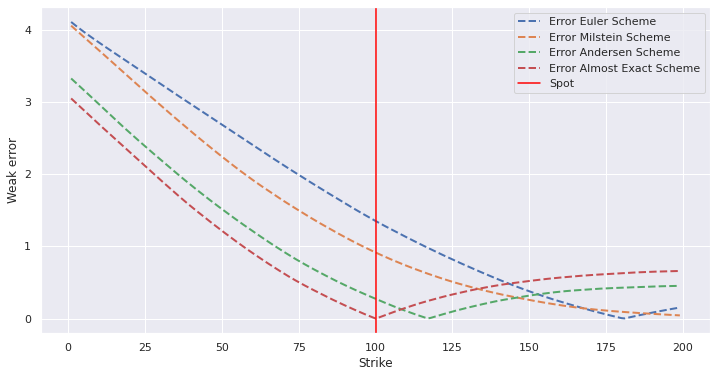

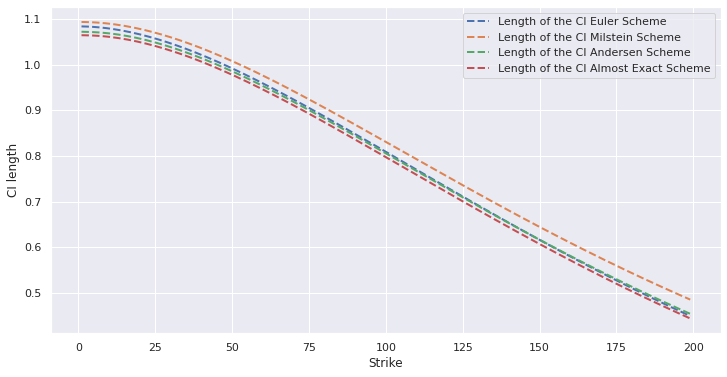

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(start,200), error_euler, linewidth=2, label = 'Error Euler Scheme', ls = '--')
plt.plot(range(start,200), error_milstein, linewidth=2, label = 'Error Milstein Scheme', ls = '--')
plt.plot(range(start,200), error_andersen, linewidth=2, label = 'Error Andersen Scheme', ls = '--')
plt.plot(range(start,200), error_almost, linewidth=2, label = 'Error Almost Exact Scheme', ls = '--')
plt.axvline(x = 100, color= "red", label = "Spot")
# plt.title('Error of the call pricing with different schemes')
plt.xlabel('Strike')
plt.ylabel('Weak error')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(start,200), ic_length_euler, linewidth=2, label = 'Length of the CI Euler Scheme', ls = '--')
plt.plot(range(start,200), ic_length_milstein, linewidth=2, label = 'Length of the CI Milstein Scheme', ls = '--')
plt.plot(range(start,200), ic_length_andersen, linewidth=2, label = 'Length of the CI Andersen Scheme', ls = '--')
plt.plot(range(start,200), ic_length_almost, linewidth=2, label = 'Length of the CI Almost Exact Scheme', ls = '--')
# plt.title('Error of the confidence intervals with different schemes')

plt.xlabel('Strike')
plt.ylabel('CI length')
plt.legend()
plt.show()

## Greeks

In [14]:
K = 100
Npaths = 2000

def Delta(x):
    '''
      Compute the Delta of Call for the 4 schemes
      Args:
          x:
            Spot Price of the Underlying
      Returns:
          Deltas of the Call of spot x for the 4 schemes
    '''
    step = 0.9
    step_2 = 0.9

    path_plus_euler = generate_heston_euler(S = x * (1 + step),kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_euler =  generate_heston_euler(S = x * (1 - step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_plus_milstein = generate_heston_milstein(S = x * (1 + step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_milstein =  generate_heston_milstein(S = x * (1 - step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_plus_andersen = generate_heston_andersen(S = x * (1 + step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_andersen =  generate_heston_andersen(S = x * (1 - step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_plus_almost_exact = generate_heston_almost_exact(S = x * (1 + step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_almost_exact =  generate_heston_almost_exact(S = x * (1 - step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    delta_euler = np.mean( (call_price(path_plus_euler,K)-call_price(path_sub_euler,K)) / (2*step*x) ) 
    delta_milstein = np.mean( (call_price(path_plus_milstein,K)-call_price(path_sub_milstein, K)) / (2*step*x) ) 
    delta_andersen = np.mean( (call_price(path_plus_andersen,K)-call_price(path_sub_andersen, K)) / (2*step_2*x) )
    delta_almost_exact = np.mean( (call_price(path_plus_almost_exact,K)-call_price(path_sub_almost_exact,K)) / (2*step_2*x) ) 
 

    return(delta_euler, delta_milstein, delta_andersen, delta_almost_exact)


def Gamma(x):
    '''
      Compute the Gamma of Call for the 4 schemes
      Args:
          x:
            Spot Price of the Underlying
      Returns:
          The Gamma of the Call of spot x for the 4 schemes
      '''
    step = 0.99
    step_2 = 0.99

    path_euler = generate_heston_euler(S = x)[0]
    path_plus_euler = generate_heston_euler(S = x * (1 + step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_euler =  generate_heston_euler(S = x * (1 - step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_milstein = generate_heston_milstein(S = x)[0]
    path_plus_milstein = generate_heston_milstein(S = x * (1 + step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_milstein =  generate_heston_milstein(S = x * (1 - step), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_andersen = generate_heston_andersen(S = x)[0]
    path_plus_andersen = generate_heston_andersen(S = x * (1 + step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_andersen =  generate_heston_andersen(S = x * (1 - step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    path_almost_exact = generate_heston_almost_exact(S = x)[0]
    path_plus_almost_exact = generate_heston_almost_exact(S = x * (1 + step_2),kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]
    path_sub_almost_exact =  generate_heston_almost_exact(S = x * (1 - step_2), kappa = kappa, theta = theta, v_0 =v_0 , xi = xi, steps = 3, T= T)[0]

    gamma_euler = np.mean( (call_price(path_plus_euler,K)-2*call_price(path_euler,K)+call_price(path_sub_euler, K)))/( (step*x)**2)
    gamma_milstein = np.mean( (call_price(path_plus_milstein,K)-2*call_price(path_milstein,K)+call_price(path_sub_milstein, K)))/( (step*x)**2)
    gamma_andersen = np.mean( (call_price(path_plus_almost_exact,K)-2*call_price(path_andersen,K)+call_price(path_sub_andersen, K)))/( (step_2*x)**2)
    gamma_almost_exact = np.mean( (call_price(path_plus_almost_exact,K)-2*call_price(path_almost_exact,K)+call_price(path_sub_almost_exact, K)))/( (step_2*x)**2)

    return(gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact )

-------------please wait for 2 min----------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Unrecognized location 'Lower left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Unrecognized location 'Lower left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


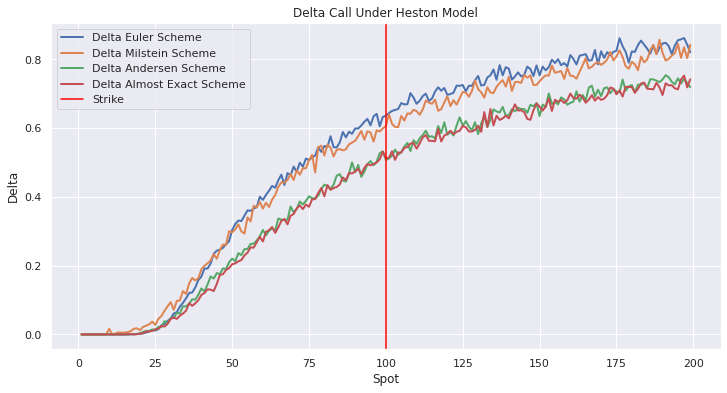

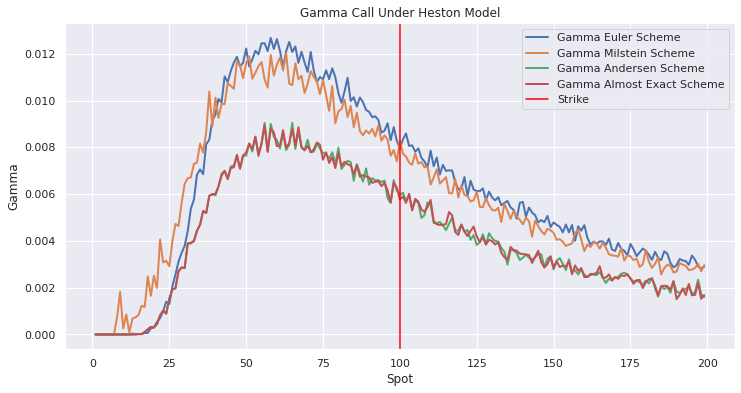

In [15]:
def compute_greeks():
    '''
      Plot the greeks 
      Args:
          NA: Plot the greeks for a range of spot
      return:
        Lists of Deltas for the four schemes of spot x

    '''
    delta_euler = []
    delta_milstein = []
    delta_andersen = []
    delta_almost_exact = []

    gamma_euler = []
    gamma_milstein =[] 
    gamma_andersen = []
    gamma_almost_exact = []

    for x in range(1,200):
        d = Delta(x)
        g = Gamma(x)
        delta_euler.append(d[0])
        delta_milstein.append(d[1])
        delta_andersen.append(d[2])
        delta_almost_exact.append(d[3])

        gamma_euler.append(g[0])
        gamma_milstein.append(g[1])
        gamma_andersen.append(g[2])
        gamma_almost_exact.append(g[3])

    return(delta_euler, delta_milstein, delta_andersen, delta_almost_exact, gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact)


print('-------------please wait for 2 min----------------------------')
delta_euler, delta_milstein, delta_andersen, delta_almost_exact, gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact = compute_greeks()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_euler, linewidth=2, label = "Delta Euler Scheme")
plt.plot(range(1,200), delta_milstein, linewidth=2, label = "Delta Milstein Scheme")
plt.plot(range(1,200), delta_andersen, linewidth=2, label = "Delta Andersen Scheme")
plt.plot(range(1,200), delta_almost_exact, linewidth=2, label = "Delta Almost Exact Scheme")
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta Call Under Heston Model')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'Lower left')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_euler, linewidth=2, label = "Gamma Euler Scheme")
plt.plot(range(1,200), gamma_milstein, linewidth=2, label = "Gamma Milstein Scheme")
plt.plot(range(1,200), gamma_andersen, linewidth=2, label = "Gamma Andersen Scheme")
plt.plot(range(1,200), gamma_almost_exact, linewidth=2, label = "Gamma Almost Exact Scheme")
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma Call Under Heston Model')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'Lower left')
plt.show()